In [2]:
import scipy.signal as signal
import numpy as np 
import os, csv

In [3]:
import matplotlib.pylab as plt

In [4]:
% matplotlib inline

In [111]:
def load_data(subject_id, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    day=1
    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)
                
    for file_name in data_file_names: 
        if subject_id in file_name: 
            subject_path = data_path + file_name
            if listen: print("loading data from subject'%s'"%file_name) 

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_id='12'): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """
    subject_data = load_data(subject_id)


    _pupil_ = [] 
    onsets  = []
    cs_type = []
    xy = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US

    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
            else: 
                xy.append([float(msg[1]), float(msg[2])])
            
        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: 
                    us_o = 1
                    cs_type[-1] =  cs_type[-1] + 'US'
                    
                    
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        i_frame = int(msg[1][ind+7:space])
                    
                    if "TRIAL_ONSET" in msg[1]:
                        onsets.append(len(_pupil_))
                        cs_type.append(msg[1][-3:])
                    
                        
    
    data = {"pupil":np.array(_pupil_), 
            "CS+":np.array(cs_pos), 
            "CS-":np.array(cs_neg), 
            "US":np.array(us_sti), 
            "movie_frame":np.array(m_frame),
            "xy":np.array(xy), 
            "onsets":np.array(onsets),
            "cs_type":cs_type}
                    

    return data



In [416]:
subjects = ['12', '08']
data = extract_data(subjects[i_subject]) ; data.keys()

dict_keys(['pupil', 'CS+', 'CS-', 'US', 'movie_frame', 'xy', 'onsets', 'cs_type'])

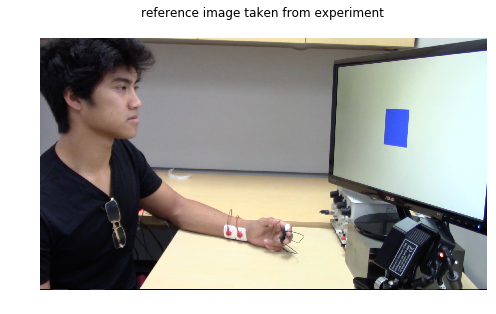

In [414]:
model_image = plt.imread('model_image.png')
y_len, x_len, _ = np.shape(model_image)
plt.figure(figsize=[8,5])
plt.axis('off')
plt.imshow(model_image)
plt.title('reference image taken from experiment\n'); 

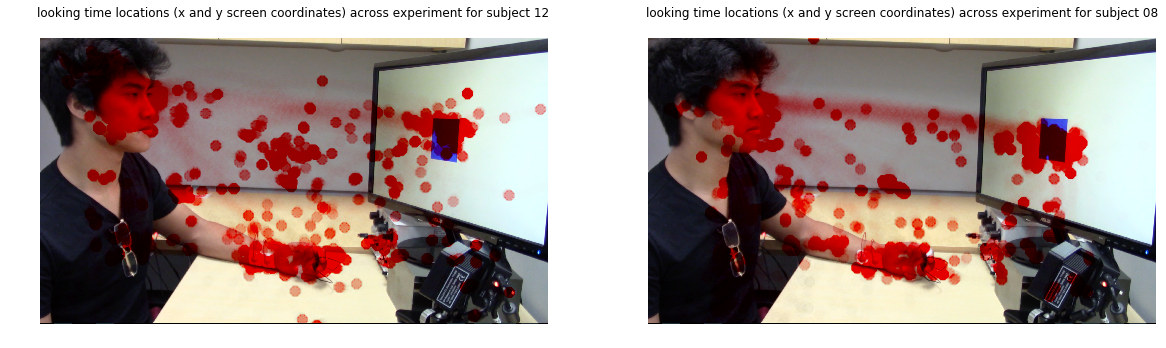

In [436]:
big_picture = 0

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    data = extract_data(subjects[i_subject])
    plt.subplot(1,2,i_subject+1)
    plt.axis('off')
    plt.imshow(model_image)
    plt.scatter(data['xy'][:,0]*1.9-200, data['xy'][:,1]*1.9-50,marker='o', s=100, alpha=.005, c = 'xkcd:red')
    plt.title('looking time locations (x and y screen coordinates) across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: 
        plt.xlim([0, x_len])
        plt.ylim([y_len, 0])

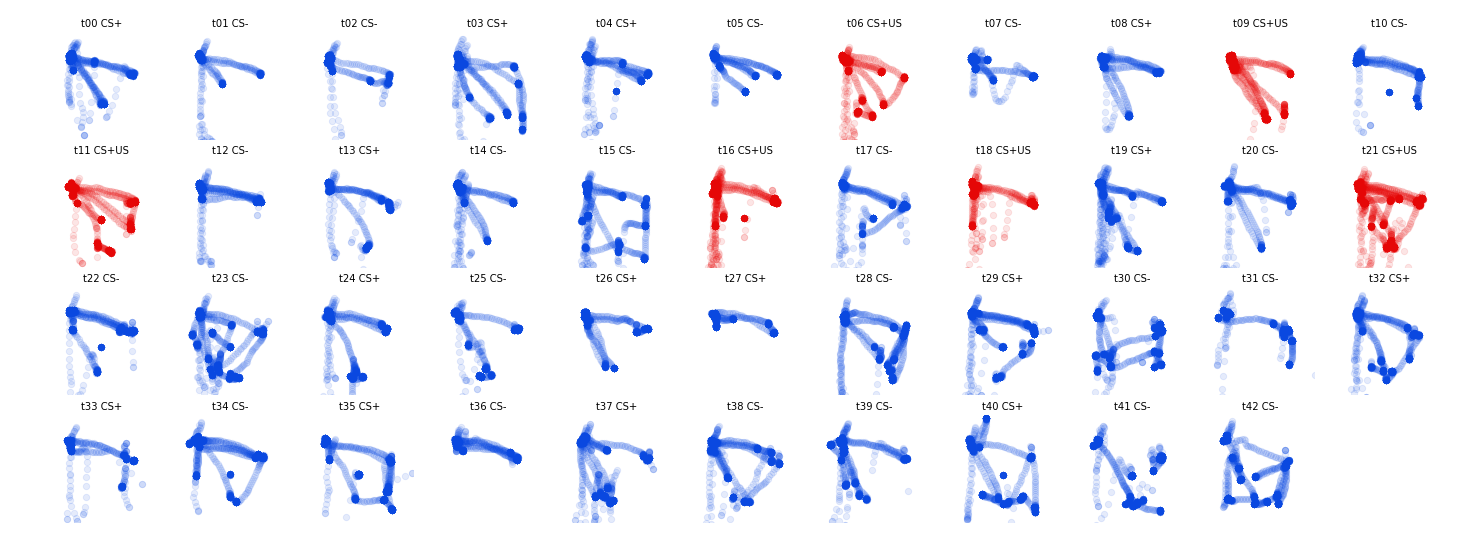

In [419]:
# interval info
_xy_ = data['xy']
#show = np.insert(data['onsets'],0, 0)
show = data['onsets']

def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

# aesthetics
plt.figure(figsize=[25,9]); 

for ii in range(len(show)-1): 
    
    plt.subplot(4,11,ii+1)
    plt.axis('off')
    plt.xlim([0, 2000]) ; 
    plt.ylim([-1000, 0])
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['cs_type'][ii])); 
    plt.title('\nt%02d %s'%(ii, data['cs_type'][ii]), fontsize=10)

```
                                is there more entropy after conditioning is over?
```


					gaze behavior across the experiment


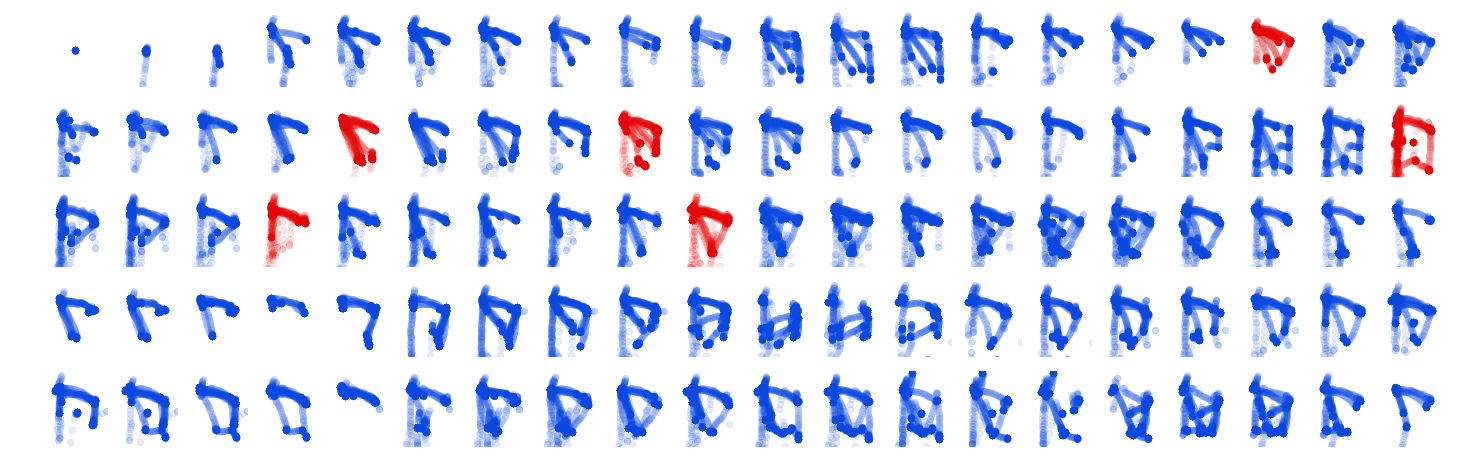

In [407]:
# aesthetics
plt.figure(figsize=[25,8]); 
# interval info

xy = e['xy']

start = 0 
end =  len(xy) 
step = round((end-start)/100)

_show_ = np.arange(start, end, step)


def US_color(interval_0, interval_1, us_onsets):
    
    color = 'xkcd:blue'
    for i_onset in us_onsets: 
        if interval_0 < i_onset < interval_1: color = 'xkcd:red' 
    return color

for ii in range(len(_show_)-1): 
    
    plt.subplot(5,20,ii+1)
    plt.axis('off')
    plt.xlim([0, 2000]) ; 
    plt.ylim([-1000, 0])
    
    if ii < 3: start = 2000
    if ii > 3: start = _show_[ii-2]
    
    color = US_color(_show_[ii], _show_[ii+1], us_onsets)
    plt.scatter(xy[start:_show_[ii+1],0],-xy[start:_show_[ii+1],1], 
                marker='o', s=40, alpha=.1, c = '%s'%color);

print('\n\t\t\t\t\tgaze behavior across the experiment')

```
                                again, more entropy after conditioning is over?
```

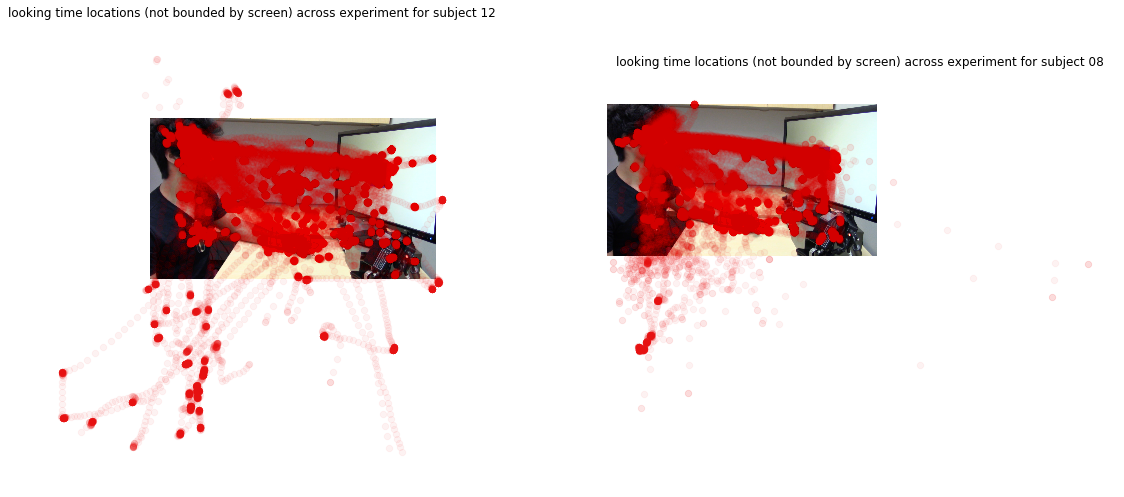

In [429]:
big_picture = 1

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    data = extract_data(subjects[i_subject])
    plt.subplot(1,2,i_subject+1)
    plt.axis('off')
    plt.imshow(model_image)
    plt.scatter(data['xy'][:,0]*1.9-200, data['xy'][:,1]*1.9-50,marker='o', s=40, alpha=.05, c = 'xkcd:red')
    plt.title('looking time locations (not bounded by screen) across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: 
        plt.xlim([0, x_len])
        plt.ylim([y_len, 0])

```
                             is that lower left shift towards their own hand? 
```

In [34]:
raw[ii]

[['37234473', ' 1454.9', '  793.2', ' 6496.0', '...'],
 ['37234475', ' 1454.8', '  793.5', ' 6494.0', '...'],
 ['37234477', ' 1455.0', '  793.5', ' 6496.0', '...'],
 ['37234479', ' 1455.2', '  793.5', ' 6497.0', '...'],
 ['37234481', ' 1455.4', '  793.4', ' 6489.0', '...'],
 ['37234483', ' 1455.4', '  793.3', ' 6481.0', '...'],
 ['37234485', ' 1455.4', '  793.1', ' 6475.0', '...'],
 ['37234487', ' 1455.5', '  793.2', ' 6478.0', '...'],
 ['37234489', ' 1455.6', '  793.4', ' 6475.0', '...'],
 ['37234491', ' 1455.7', '  793.8', ' 6468.0', '...'],
 ['37234493', ' 1455.6', '  794.0', ' 6461.0', '...'],
 ['37234495', ' 1455.4', '  794.1', ' 6455.0', '...'],
 ['37234497', ' 1455.2', '  794.2', ' 6451.0', '...'],
 ['37234499', ' 1455.4', '  794.3', ' 6445.0', '...'],
 ['37234501', ' 1455.7', '  794.6', ' 6443.0', '...'],
 ['37234503', ' 1455.9', '  794.7', ' 6440.0', '...'],
 ['37234505', ' 1455.9', '  794.7', ' 6440.0', '...'],
 ['MSG',
  '37234506 -14562 !V VFRAME 10734 0 0 /Users/ssnl_booth